In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.integrate import quad, nquad, dblquad
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime
from pathlib import Path
import pickle as pkl

my_path = Path('/Users/adameshel/Documents/Python_scripts/spatial_interpolation_with_cmls/Autocorr/')

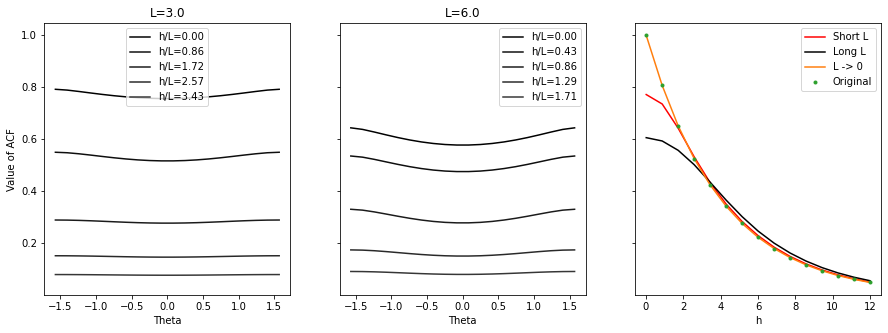

In [4]:
full_expr = False # Full or simplified expression
printing = True
pic = 0
factor = 2.0
eps = 0.0

# Define parameters
alpha = 4.0
beta = 1.0
thetas = np.linspace(-np.pi/2+eps, np.pi/2-eps, 20)
phis = np.linspace(-np.pi/2+eps, np.pi/2-eps, 20)
L = 3.0


def make_hs():
    hs = np.linspace(0.01,12.0,15)
    return hs

hs = make_hs()

def acf_original(h, alpha, beta):
    return beta * np.exp(-(h/alpha)) 

def acf(t1,t2,h,L,theta,phi=-999):
    '''Auto-Correlation Function'''
    # the full expression under the sqrt
    if phi != -999: 
        sq = t2**2 + (h/L)**2 + 2*t2*(h/L)*np.cos(theta-phi) +\
        t1**2 -2*t1*(t2*np.sin(theta)+(h/L)*np.sin(phi)) + 1e-8
    # the short expression where theta=phi
    else: 
        sq = (t2+(h/L))**2 + t1**2 -2*t1*(t2+(h/L))*np.sin(theta) + 1e-8
    if sq < 0:
        print(sq, theta, phi)
    return beta * np.exp((-L * np.sqrt(sq)) / alpha)

def Rr_ang(h,L,thetas,phis,full_expr=False):
    '''Function that loops over thetas and returns 
    the solution to the double integral of acf, for the simplified expression,
    where theta equals phi (False) and for the full one (True).'''
    rs = []
    if full_expr is False:
        phis = np.array([-999])  
    for theta in thetas:
        r = []
        for phi in phis:    
            # perform the double integral
            result, err = nquad(acf,[[-0.5,0.5],[-0.5,0.5]],args=(h,L,theta,phi))
            r.append(result)
        r = np.array(r)
        rs.append(r)
    rs = np.array(rs)
    return rs, np.nanmean(rs) 

def compute_acf(hs,L,pic=0,printing=False):
    avgs = []
    i = 0; j = 0
    c = np.linspace(0.0,0.8,int(len(hs)/3)+1)
    for h in hs:
        acf_theta, avg = Rr_ang(h,L,thetas,phis,full_expr=full_expr) 
        avgs.append(avg)
        if printing and i%3==0:
            temp = h/L
            col = (c[j]/1.5, c[j]/1.5, c[j]/1.5)
            j += 1
            ax[pic].plot(thetas, acf_theta, color=col, label='h/L=%.2f' %temp)
        i += 1
    return np.array(avgs)

if printing:
    fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
Rr = compute_acf(hs,L,pic,printing)
pic += 1
if printing:
    ax[2].plot(hs,Rr,'r',label='Short L')
    ax[0].set_xlabel('Theta')
    ax[0].set_ylabel('Value of ACF')
    ax[0].legend()
    ax[0].set_title('L=%.1f' %L)

L = L * factor
Rr = compute_acf(hs,L,pic,printing)
if printing:
    ax[2].plot(hs,Rr,'k',label='Long L')
    ax[1].set_xlabel('Theta')
    ax[1].legend()
    ax[1].set_title('L=%.1f' %L)
    ax[2].set_xlabel('h')

### Sanity check 
L = 0.01
Rr = compute_acf(hs,L,printing=False)
if printing:
    ax[2].plot(hs,Rr,'C1',label='L -> 0')

Rr_orig = []
for h in hs:
    temp = acf_original(h, alpha, beta)
    Rr_orig.append(temp)
Rr_orig = np.array(Rr_orig)
if printing:
    ax[2].plot(hs,Rr_orig,'.C2',label='Original')
    ax[2].legend()

[2.07618902 0.42437279]


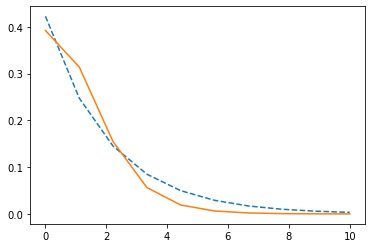

In [4]:
popt, pcov = curve_fit(f=acf_original, 
                       xdata=hs, 
                       ydata=Rr)
alpha_opt, beta_opt = popt
print(popt)
fig, ax = plt.subplots()
ax.plot(hs,acf_original(hs,alpha_opt,beta_opt), '--C0')
ax.plot(hs, Rr, 'C1')

In [13]:
print('Ls_hs_Rrmat_a_%ib_%i' %(alpha,beta) + str(full_expr) + '.dat')

Ls_hs_Rrmat_a_4b_1False.dat


In [18]:
Ls = np.linspace(0.01,30.0,10)
    
Rr_mat = np.zeros((len(Ls),len(hs)))
total_time = datetime.datetime.now() - datetime.datetime.now()
for i,L in enumerate(Ls):
    then = datetime.datetime.now()
    print(L)
    Rr_mat[i,:] = compute_acf(hs, L)
    now = datetime.datetime.now()
    diff = now-then
    print('diff=%s' % diff)
    total_time += diff
    print('total=%s' % total_time)
    print('\n')

## Pickle data
data = [Ls, hs, Rr_mat, alpha, beta]
with open(my_path.joinpath('Ls_hs_Rrmat_a_%ib_%i' %(alpha,beta) + str(full_expr) + '.dat'), 'wb') as f:
    pkl.dump(len(data), f)
    for var in data:
        pkl.dump(var, f)
f.close()

10.006666
diff=0:01:05.632092
total=0:01:05.632081




### Restore pickled data

In [19]:
data2 = []
with open(my_path.joinpath('Ls_hs_Rrmat_a_%ib_%i' %(alpha,beta) + str(full_expr) + '.dat'), 'rb') as f:
    for _ in range(pkl.load(f)):
        data2.append(pkl.load(f))
f.close()
Ls=data2[0]; hs=data2[1]; Rr_mat=data2[2]; alpha=data[3]; beta=data[4]

<ipython-input-16-4110e8f02bf0>:5: RuntimeWarning: overflow encountered in exp
  return alpha_0*np.exp(x/(a*alpha_0))


Text(0.5, 1.0, 'Model:  $\\beta$(L)=$\\beta_0$e$^{-L/(a\\beta_0)}$\na=4.13  $\\beta_0$=1.01\nr$^2$=0.998')

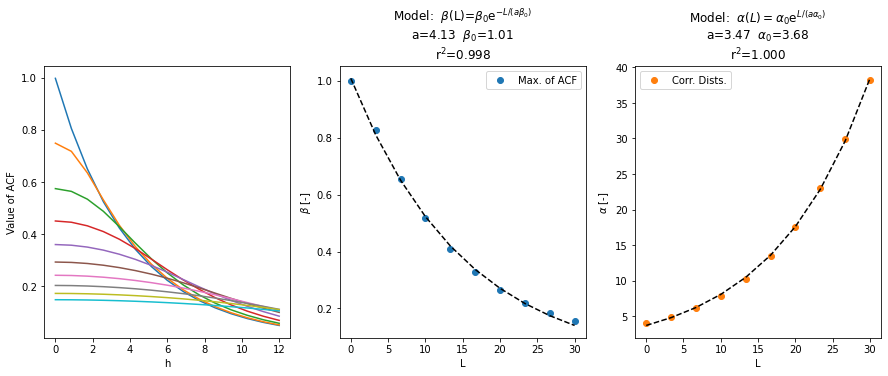

In [16]:
alpha_beta_95 = False # When false alpha and beta are optimized

def alpha_L(x,a,alpha_0):
#     return a*x + alpha
    return alpha_0*np.exp(x/(a*alpha_0))
########################
def beta_L(x,a,beta_0):
    return beta_0*np.exp(-x/(a*alpha_0))
########################

hc_l = [] # correlation distance list
s_l = [] # sill list
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(len(Rr_mat[:,0])):
    ax[0].plot(hs,Rr_mat[i])
    if alpha_beta_95:
        # Max value of ACF
        s_l.append(Rr_mat[i][0])
        # Correlatio distance as the h where 
        #the value of ACF decreases in 95%
        hc_l.append(hs[np.sum(Rr_mat[i] >= np.nanmax(Rr_mat[i]) * 0.05) -1])
    else:

        popt, _ = curve_fit(f=acf_original, 
                               xdata=hs, 
                               ydata=Rr_mat[i])
        alpha_opt, beta_opt = popt

        s_l.append(beta_opt)
        hc_l.append(alpha_opt)
    
betas = np.array(s_l)
alphas = np.array(hc_l)

ax[1].scatter(Ls,betas,c='C0',label='Max. of ACF')
ax[1].legend()
ax[2].scatter(Ls,alphas,c='C1',label='Corr. Dists.')
ax[2].legend()

ax[0].set_xlabel('h')
ax[1].set_xlabel('L')
ax[2].set_xlabel('L')
ax[0].set_ylabel('Value of ACF')
ax[1].set_ylabel(r'$\beta$ [-]')
ax[2].set_ylabel(r'$\alpha$ [-]')

palpha, _ = curve_fit(f=alpha_L,xdata=Ls,ydata=alphas)
alpha_a, alpha_0 = palpha
line = alpha_L(Ls, alpha_a, alpha_0)
r2 = round(np.corrcoef(alphas,line)[0,1],3)**2
ax[2].plot(Ls,line,'--k')
# ax[2].set_title(r'Model:  $\alpha$(L)=aL+$\alpha_0$'
#                 '\n'r'a=%.2f $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(alpha_a, alpha, r2))
ax[2].set_title(r'Model:  $\alpha(L)=$$\alpha_0$e$^{L/(a\alpha_0)}$'
                '\n'r'a=%.2f  $\alpha_0$=%.2f''\n''r$^2$=%.3f' %(alpha_a, alpha_0, r2))

pbeta, _ = curve_fit(f=beta_L,xdata=Ls,ydata=betas)
beta_a, beta_0 = pbeta
line = beta_L(Ls, beta_a, beta_0)
r2 = round(np.corrcoef(betas,line)[0,1],3)**2
ax[1].plot(Ls,line,'--k')
ax[1].set_title(r'Model:  $\beta$(L)=$\beta_0$e$^{-L/(a\beta_0)}$'
                '\n'r'a=%.2f  $\beta_0$=%.2f''\n''r$^2$=%.3f' %(beta_a, beta_0, r2))

In [75]:
rows = 2
cols = 2
Ls = np.linspace(0.5, 15.0, rows*cols)
hs = np.linspace(0.5, 20.0, 6)
ms_mat = np.zeros((len(Ls),len(hs)))
for i,L in enumerate(Ls):
    print(L)
    ms = []
    for h in hs:
        Rr, m = Rr_ang(h,L) # long
        ms.append(m)
    ms_mat[i,:] = np.array(ms)

0.5
5.333333333333333
10.166666666666666
15.0


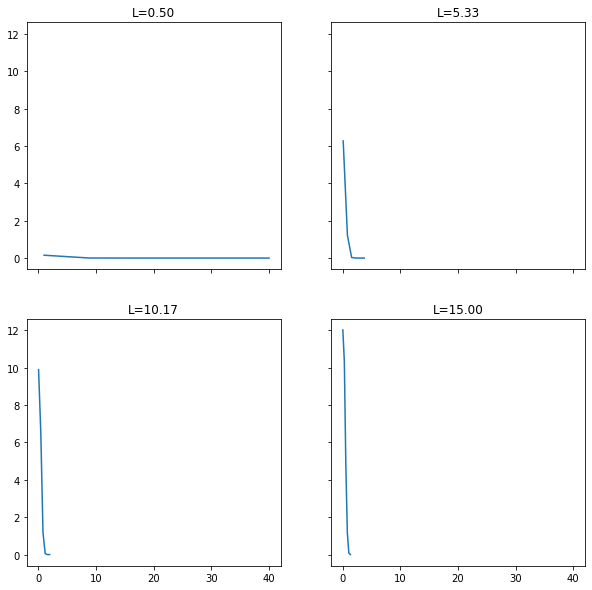

In [82]:
fig, ax = plt.subplots(rows, cols, figsize=(10,10), sharey=True, sharex=True)
l=0
for r in range(rows):
    for c in range(cols):
        ax[r,c].plot(hs/Ls[l], ms_mat[l])
        ax[r,c].set_title('L=%.2f' %Ls[l])
        l += 1


Text(0, 0.5, 'f')

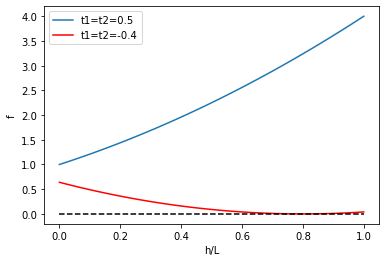

In [28]:
theta = -np.pi/2
L = 10
hs = np.linspace(0,10,70)
t2 = 0.5
t1 = t2
sq = []
def f(t1,t2,h,L,theta):
    '''The expression under the square root'''
    return (t2+(h/L))**2 + t1**2 -2*t1*(t2+(h/L))*np.sin(theta)
for h in hs:
    sq.append(f(t1,t2,h,L,theta))
sq = np.array(sq)
plt.plot(hs/L,sq,label='t1=t2=%.1f' %t1)

sq = []
t2 = -0.4
t1 = t2
for h in hs:
    sq.append(f(t1,t2,h,L,theta))
sq = np.array(sq)
plt.plot(hs/L,sq,'r',label='t1=t2=%.1f' %t1)
plt.plot(hs/L,sq*0,'--k')
plt.legend()
plt.xlabel('h/L')
plt.ylabel('f')